# Pre-requisites

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit

import os
import shutil


# Main Analysis

## Algorithm: Area-Based Crystallinity


Replaces the simple calculate_local_r2 function with a more comprehensive calculate_peak_metrics function that computes multiple metrics:
- Local R² value for both fits and the improvement
- RMSE (Root Mean Square Error) improvement
- Residual sum improvement
- Peak intensity relative to baseline
- Signal-to-noise ratio in the peak region
- Correlation between the data and the contribution of the peak
- A composite quality score that weights these metrics

The `init_guess` parameter is established in the _perform_fitting function through a multi-step process before being used in curve_fit
1. First, an empty list is created: `init_guess = []`

2. Then the function builds this list by appending initial parameter values for each peak in sets of 3 parameters (amplitude, position, width):

    - For known crystalline peaks:

        - If a detected peak is near a known position, it uses that peak's observed height and width
        - If no detected peak is nearby, it estimates parameters based on the intensity at that position
        - Each set adds [height, known_position, width] to `init_guess`

    - For detected peaks not near known crystalline positions:
        - Checks for overlapping peaks and adjusts width estimates accordingly
        - Adds [peak_height, position, width_estimate] to `init_guess`

    - For amorphous background peaks:
        - Uses mean intensity and wider widths
        - Adds [mean_intensity/2, position, 5.0] for each amorphous peak

    - Fallback option if no components were added:
        - Adds a single broad background component [0.5, 25, 10.0]

3. The resulting `init_guess` is a flattened list of all parameters in triplets. For example, if there are 2 crystalline peaks and 2 amorphous peaks, `init_guess` would contain 12 values (4 peaks × 3 parameters each).

4. This `init_guess` is then passed as the p0 parameter to curve_fit, providing the optimization algorithm with a starting point close to the expected solution, which helps it converge faster and avoid local minima.

5. The `bounds_low` and `bounds_high` arrays are built correspondingly to establish constraints for each parameter, further improving the fitting process.

In [10]:
def _perform_fitting_fast(two_theta, baseline_corrected_intensity, known_crys_peaks, known_amorp_peaks,
                    peak_data, height_width_threshold, with_crystalline=True, 
                    known_peak_tolerance=1.0):
    """
    Internal helper function to perform the XRD spectrum fitting process.
    This encapsulates fitting and classification logic using pre-detected peaks.
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    baseline_corrected_intensity : array-like
        Baseline-corrected and normalized intensity values
    known_crys_peaks : list
        List of known crystalline peak positions from literature
    known_amorp_peaks : list
        List of known amorphous peak positions
    peak_data : dict
        Dictionary containing pre-detected peak information (positions, heights, etc.)
    height_width_threshold : float
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    with_crystalline : bool, default=True
        Whether to include crystalline components in the fit
    known_peak_tolerance : float, default=1.0
        Tolerance in degrees for matching detected peaks to known peak positions
        
    Returns:
    --------
    dict
        Dictionary containing fitting results, parameters and metrics
    """
    # --- Extract peak data ---
    all_peaks = peak_data['all_peaks']
    major_peaks = peak_data['major_peaks'] 
    peak_positions = peak_data['peak_positions']
    peak_heights = peak_data['peak_heights']
    peak_widths_degrees = peak_data['peak_widths']
    
    # --- Set Up Initial Guesses ---
    init_guess = []
    
    # Add known crystalline peaks if in crystalline fitting mode
    if with_crystalline and known_crys_peaks:
        for known_pos in known_crys_peaks:
            # Check if a detected peak is near this position
            nearby_peak_idx = None
            for i, pos in enumerate(peak_positions):
                if abs(pos - known_pos) < known_peak_tolerance:
                    nearby_peak_idx = i
                    break
                    
            if nearby_peak_idx is not None:
                # Use the detected peak's height and estimate width
                height = peak_heights[nearby_peak_idx]
                width = peak_widths_degrees[nearby_peak_idx] if nearby_peak_idx < len(peak_widths_degrees) else 0.5
                init_guess.extend([height, known_pos, width])
            else:
                # No nearby detected peak, estimate parameters based on data at this position
                nearby_idx = np.argmin(np.abs(two_theta - known_pos))
                height_estimate = baseline_corrected_intensity[nearby_idx] * 0.8
                init_guess.extend([height_estimate, known_pos, 0.5])
    
    # Add detected peaks not near known crystalline peaks if in crystalline mode
    if with_crystalline:
        for i, pos in enumerate(peak_positions):
            # Skip if this peak is already accounted for (near a known peak)
            if known_crys_peaks and any(abs(pos - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks):
                continue
                
            # Check if this peak might be overlapping with others
            is_overlapping = False
            for j, other_pos in enumerate(peak_positions):
                if i != j and abs(pos - other_pos) < 1.0:
                    is_overlapping = True
                    break
            
            # Determine appropriate width estimate
            if i < len(peak_widths_degrees):
                width_estimate = peak_widths_degrees[i]
                # Adjust width for overlapping peaks
                if is_overlapping:
                    width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
            else:
                width_estimate = 0.5  # Default if width couldn't be determined
            
            # Add parameters [amplitude, position, width]
            init_guess.extend([peak_heights[i], pos, width_estimate])
    
    # Add amorphous background peaks
    if not known_amorp_peaks:
        # Default amorphous peaks if not specified
        known_amorp_peaks = [20, 30]
        
    num_amorphous_peaks = len(known_amorp_peaks)
    mean_intensity = np.mean(baseline_corrected_intensity)
    
    for pos in known_amorp_peaks:
        init_guess.extend([mean_intensity/2, pos, 5.0])  # amplitude, position, width
    
    # If no components were added at all, add a minimal set
    if len(init_guess) == 0:
        # Add a broad amorphous component
        init_guess.extend([0.5, 25, 10.0])  # amplitude, position, width
        num_amorphous_peaks = 1
    
    # --- Set up boundary constraints ---
    bounds_low = []
    bounds_high = []
    
    # For each parameter triplet in the initial guess
    param_index = 0
    while param_index < len(init_guess):
        amp = init_guess[param_index]
        center = init_guess[param_index + 1]
        width = init_guess[param_index + 2]
        
        # Check if this is likely a crystalline peak based on its width or if it's a known crystalline position
        is_crystalline = False
        if with_crystalline:
            if width < 2.0:  # Width-based classification
                is_crystalline = True
            elif known_crys_peaks:  # Position-based classification
                is_crystalline = any(abs(center - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks)
        
        if is_crystalline:
            # Crystalline peak bounds
            bounds_low.extend([0, center - 0.5, 0.1])
            bounds_high.extend([np.inf, center + 0.5, 2.0])
        else:
            # Amorphous peak bounds
            bounds_low.extend([0, center - 5, 3.0])
            bounds_high.extend([np.inf, center + 5, 15.0])
            
        param_index += 3
    
    # --- Perform Gaussian Fitting ---
    try:
        # Define Gaussian function for fitting
        def gaussian(x, A, x0, sigma):
            """Gaussian function with parameters amplitude, center, and width"""
            return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
        
        def multi_gaussian(x, *params):
            """Fit multiple Gaussian peaks simultaneously"""
            num_peaks = len(params) // 3
            y_fit = np.zeros_like(x)
            for i in range(num_peaks):
                amp = params[3*i]
                center = params[3*i+1]
                width = params[3*i+2]
                y_fit += gaussian(x, amp, center, width)
            return y_fit
        
        # Perform the fit
        popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                              p0=init_guess, bounds=(bounds_low, bounds_high),
                              maxfev=20000)  # Increase maximum function evaluations
    except Exception as e:
        print(f"Fitting error: {str(e)}")
        print("Falling back to initial guess parameters")
        popt = np.array(init_guess)
    
    # --- Separate Components Based on Height-to-Width Ratio ---
    crystalline_params = []
    amorphous_params = []
    
    # Start with ALL known crystalline peak positions from the global reference
    all_known_crys_peaks = []
    if hasattr(fit_xrd_spectrum_fast, '_all_known_crys_peaks') and fit_xrd_spectrum_fast._all_known_crys_peaks:
        all_known_crys_peaks = fit_xrd_spectrum_fast._all_known_crys_peaks.copy()
    
    # Add any specifically passed peaks that aren't already included
    if known_crys_peaks:
        for pos in known_crys_peaks:
            if pos not in all_known_crys_peaks:
                all_known_crys_peaks.append(pos)
                
    # Process fitted parameters
    for i in range(0, len(popt), 3):
        if i+2 >= len(popt):  # Safety check
            break
            
        amp = popt[i]
        center = popt[i+1]
        width = popt[i+2]
        hw_ratio = amp / width if width > 0 else 0  # Height-to-width ratio
        
        # Skip peaks with near-zero amplitude
        if amp < 0.001:
            continue
        
        # Check if this matches ANY known crystalline peak position
        is_known_crys_peak = False
        if all_known_crys_peaks and with_crystalline:
            is_known_crys_peak = any(abs(center - known_pos) < known_peak_tolerance 
                                  for known_pos in all_known_crys_peaks)
        
        # Classify peak - consider both ratio and position
        # if with_crystalline and ((is_known_crys_peak and width < 1.0) or (hw_ratio > height_width_threshold and width < 1.0)):
        if with_crystalline and is_known_crys_peak and hw_ratio > height_width_threshold and width < 1.0:
            # This is likely a crystalline peak
            # Print information why this is classified as a crystalline peak
            print(f"Classifying peak at {center:.2f}° as crystalline: "
                f"height/width={hw_ratio:.2f}, width={width:.2f}°"
                f"{' (known position)' if is_known_crys_peak else ''}")
            crystalline_params.extend([amp, center, width])
        else:
            # This is likely an amorphous peak
            amorphous_params.extend([amp, center, width])
    
    # --- Calculate Individual Components ---
    crystalline_fit = np.zeros_like(two_theta)
    if crystalline_params:
        crystalline_fit = multi_gaussian(two_theta, *crystalline_params)
        
    amorphous_fit = np.zeros_like(two_theta)
    if amorphous_params:
        amorphous_fit = multi_gaussian(two_theta, *amorphous_params)
        
    total_fit = crystalline_fit + amorphous_fit
    
    # --- Calculate Crystallinity Index ---
    area_crystalline = np.trapz(crystalline_fit, two_theta)
    area_amorphous = np.trapz(amorphous_fit, two_theta)
    area_total = area_crystalline + area_amorphous
    
    if area_total > 0:
        crystallinity = (area_crystalline / area_total) * 100
    else:
        crystallinity = 0.0
    
    # --- Calculate Goodness of Fit ---
    residuals = baseline_corrected_intensity - total_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((baseline_corrected_intensity - np.mean(baseline_corrected_intensity))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    rmse = np.sqrt(np.mean(residuals**2))
    
    # --- Organize fitted peaks for reporting ---
    crystalline_peak_data = []
    for i in range(0, len(crystalline_params), 3):
        if i+2 >= len(crystalline_params):
            break
        crystalline_peak_data.append({
            'amplitude': crystalline_params[i],
            'position': crystalline_params[i+1], 
            'width': crystalline_params[i+2],
            'hw_ratio': crystalline_params[i] / crystalline_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     crystalline_params[i], 
                                     crystalline_params[i+1], 
                                     crystalline_params[i+2]), 
                            two_theta)
        })
    
    amorphous_peak_data = []
    for i in range(0, len(amorphous_params), 3):
        if i+2 >= len(amorphous_params):
            break
        amorphous_peak_data.append({
            'amplitude': amorphous_params[i],
            'position': amorphous_params[i+1], 
            'width': amorphous_params[i+2],
            'hw_ratio': amorphous_params[i] / amorphous_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     amorphous_params[i], 
                                     amorphous_params[i+1], 
                                     amorphous_params[i+2]), 
                            two_theta)
        })
    
    # Return fitting results
    results = {
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'optimized_parameters': popt,
        'crystalline_params': crystalline_params,
        'amorphous_params': amorphous_params,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'total_fit': total_fit,
        'crystallinity': crystallinity,
        'r_squared': r_squared,
        'rmse': rmse,
        'residuals': residuals,
        'crystalline_peak_data': crystalline_peak_data,
        'amorphous_peak_data': amorphous_peak_data,
        'gaussian_function': gaussian,
        'multi_gaussian_function': multi_gaussian
    }
    
    return results

def fit_xrd_spectrum_fast(two_theta, intensity, known_crys_peaks=None, known_amorp_peaks=None, 
                     height_width_threshold=0.3, min_prominence=0.008, 
                     min_r_squared=0.998, amorphous_r_squared=0.80, visualise=True,
                     max_combination_size=4):
    """
    Efficient XRD analysis function using a build-up strategy:
    1. Start with amorphous-only fit
    2. Test individual crystalline peaks and combinations for significance in localized regions
    3. Combine successful crystalline peaks for final model
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    intensity : array-like
        Array of corresponding intensity values
    known_crys_peaks : list or None, optional
        List of known crystalline peak positions from literature
    known_amorp_peaks : list or None, optional
        List of known amorphous peak positions
    height_width_threshold : float, default=0.3
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    min_prominence : float, default=0.008
        Minimum prominence for peak detection
    min_r_squared : float, default=0.85
        Minimum R² value for considering a fit successful
    amorphous_r_squared : float, default=0.80
        Lower threshold for amorphous-only fit acceptability
    visualise : bool, default=True
        Whether to generate visualization plots
    max_combination_size : int, default=3
        Maximum number of peaks to include in combinations testing
        
    Returns:
    --------
    dict
        Dictionary containing peak information, fitted parameters, and crystallinity
    """
    # Set default values if None is provided
    if known_crys_peaks is None:
        known_crys_peaks = []  
        
    if known_amorp_peaks is None:
        known_amorp_peaks = []  # Default amorphous peak positions
    
    # Store all known crystalline peaks in a class variable for reference
    # This allows _perform_fitting to access all known peaks even when testing individual peaks
    fit_xrd_spectrum_fast._all_known_crys_peaks = known_crys_peaks.copy() if known_crys_peaks else []
    
    # --- Step 1: Data Preprocessing ---
    # Normalize intensity
    normalized_intensity = intensity / np.max(intensity)
    
    # Smooth the normalized data
    smoothed_intensity = savgol_filter(normalized_intensity, window_length=15, polyorder=3)
    
    # --- Step 2: Baseline Correction ---
    # Method: Find the minimum value of smoothed intensity as baseline level
    baseline_level = np.min(smoothed_intensity)
    
    # Subtract baseline level from smoothed intensity
    baseline_corrected_intensity = smoothed_intensity - baseline_level
    
    # Ensure no negative values
    baseline_corrected_intensity = np.maximum(baseline_corrected_intensity, 0)
    
    # Renormalize after baseline correction
    if np.max(baseline_corrected_intensity) > 0:
        baseline_corrected_intensity = baseline_corrected_intensity / np.max(baseline_corrected_intensity)
    
    # --- Step 3: Assess Signal Quality ---
    # Calculate signal-to-noise ratio
    signal_mean = np.mean(baseline_corrected_intensity)
    noise_estimate = np.std(baseline_corrected_intensity - 
                           savgol_filter(baseline_corrected_intensity, window_length=21, polyorder=3))
    snr = signal_mean / noise_estimate if noise_estimate > 0 else 0
    
    # Adjust peak detection parameters based on signal quality
    adjusted_min_prominence = min_prominence
    if snr < 5:  # Low SNR
        print(f"Low signal-to-noise ratio detected ({snr:.2f}). Adjusting detection parameters.")
        adjusted_min_prominence = min_prominence * 1.5  # Increase prominence threshold for noisy data
    
    # Check if data has any significant peaks at all
    max_peak_height = np.max(baseline_corrected_intensity)
    is_mostly_amorphous = max_peak_height < 0.1  # Very low peak height suggests mostly amorphous
    
    if is_mostly_amorphous:
        print("Sample appears to be predominantly amorphous.")
    
    # --- Step 4: Define Gaussian Functions ---
    def gaussian(x, A, x0, sigma):
        """Gaussian function with parameters amplitude, center, and width"""
        return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
    
    def multi_gaussian(x, *params):
        """Fit multiple Gaussian peaks simultaneously"""
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)
        for i in range(num_peaks):
            amp = params[3*i]
            center = params[3*i+1]
            width = params[3*i+2]
            y_fit += gaussian(x, amp, center, width)
        return y_fit
    
    # --- Step 5: Run Peak Detection (JUST ONCE) ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=adjusted_min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=adjusted_min_prominence,  
                             width=10,         
                             distance=50)      
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=adjusted_min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # Create peak_data dictionary to pass to the fitting function
    peak_data = {
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees
    }
    
    # --- Step 6: Build-Up Fitting Strategy ---
    phase_success = {"amorphous": False, "individual_peaks": False, "combinations": False, "combined": False}
    fitting_results = {}
    
    # PHASE 1: Start with amorphous-only fit
    print("\nPhase 1: Performing amorphous-only fit...")
    amorphous_results = _perform_fitting_fast(two_theta, baseline_corrected_intensity,
                                       [], known_amorp_peaks, peak_data,
                                       height_width_threshold, with_crystalline=False)
    
    # Store amorphous-only results
    fitting_results["amorphous"] = {
        "name": "Amorphous Only",
        "model": amorphous_results
    }
    
    # Check if amorphous fit is excellent (exceeds normal threshold)
    if amorphous_results['r_squared'] >= min_r_squared:
        print(f"Phase 1: EXCELLENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
        phase_success["amorphous"] = True
        best_fit = amorphous_results
        best_fit_name = "Amorphous Only"
    else:
        # Check if amorphous fit is at least acceptable
        amorphous_acceptable = amorphous_results['r_squared'] >= amorphous_r_squared
        if amorphous_acceptable:
            print(f"Phase 1: ACCEPTABLE - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
            phase_success["amorphous"] = True
        else:
            print(f"Phase 1: INSUFFICIENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
    
    # PHASE 2: Test individual crystalline peaks and combinations if we have any
    successful_peaks = []
    peak_metrics = {}
    best_individual_r2 = 0
    best_individual_results = None
    best_individual_peak = None
    
    # For storing combination results
    combination_results = {}
    best_combination_r2 = 0
    best_combination = None
    best_combination_results = None
    
    if known_crys_peaks:
        # Function to calculate comprehensive metrics for judging peak quality
        def calculate_peak_metrics(peak_pos, data, fit1, fit2, two_theta, window_width=4.0):
            """
            Calculate multiple metrics to evaluate fit quality in region around a peak.
            
            Parameters:
            -----------
            peak_pos : float
                Peak position in degrees
            data : array-like
                Original data
            fit1 : array-like
                First fit to compare (usually with peak)
            fit2 : array-like
                Second fit to compare (usually without peak)
            two_theta : array-like
                2θ angles in degrees
            window_width : float, default=4.0
                Width of window around peak to analyze
                
            Returns:
            --------
            dict
                Dictionary containing multiple metrics
            """
            # Define window boundaries (±window_width/2 degrees around peak)
            window_min = peak_pos - window_width/2
            window_max = peak_pos + window_width/2
            
            # Get indices for the window
            window_indices = np.where((two_theta >= window_min) & (two_theta <= window_max))[0]
            
            if len(window_indices) < 5:  # Need minimum points for meaningful calculation
                return {
                    'local_r2_fit1': 0.0,
                    'local_r2_fit2': 0.0,
                    'local_r2_improvement': 0.0,
                    'rmse_improvement': 0.0,
                    'residual_sum_improvement': 0.0,
                    'peak_intensity': 0.0,
                    'signal_to_noise': 0.0,
                    'data_peak_correlation': 0.0,
                    'quality_score': 0.0
                }
                
            # Extract local data in window
            local_data = data[window_indices]
            local_fit1 = fit1[window_indices]
            local_fit2 = fit2[window_indices]
            local_x = two_theta[window_indices]
            
            # Local R² calculations
            local_residuals1 = local_data - local_fit1
            local_residuals2 = local_data - local_fit2
            
            local_ss_res1 = np.sum(local_residuals1**2)
            local_ss_res2 = np.sum(local_residuals2**2)
            
            local_ss_tot = np.sum((local_data - np.mean(local_data))**2)
            
            if local_ss_tot == 0:  # Avoid division by zero
                local_r2_fit1 = 0.0
                local_r2_fit2 = 0.0
            else:
                local_r2_fit1 = 1 - (local_ss_res1 / local_ss_tot)
                local_r2_fit2 = 1 - (local_ss_res2 / local_ss_tot)
            
            # RMSE improvement (negative means fit1 is better)
            local_rmse1 = np.sqrt(np.mean(local_residuals1**2))
            local_rmse2 = np.sqrt(np.mean(local_residuals2**2))
            rmse_improvement = local_rmse2 - local_rmse1
            
            # Sum of absolute residuals improvement (negative means fit1 is better)
            residual_sum1 = np.sum(np.abs(local_residuals1))
            residual_sum2 = np.sum(np.abs(local_residuals2))
            residual_sum_improvement = residual_sum2 - residual_sum1
            
            # Calculate peak intensity relative to baseline
            baseline = np.percentile(local_data, 10)  # Use lower percentile as baseline estimate
            peak_intensity = np.max(local_data) - baseline
            
            # Calculate local SNR
            noise_estimate = np.std(local_residuals1) 
            signal_to_noise = peak_intensity / noise_estimate if noise_estimate > 0 else 0
            
            # Calculate correlation between data and fit difference
            fit_difference = local_fit1 - local_fit2  # How much the peak adds to the fit
            data_minus_fit2 = local_data - local_fit2  # What's missing from fit2
            
            # Calculate correlation coefficient between these two
            try:
                correlation = np.corrcoef(fit_difference, data_minus_fit2)[0, 1]
                # Fix potential NaN values
                if np.isnan(correlation):
                    correlation = 0.0
            except:
                correlation = 0.0
                
            # Calculate a composite quality score that balances multiple metrics
            # Higher score means the peak is more likely to be real and significant
            quality_score = (0.4 * signal_to_noise / 10.0 +  # Weight SNR (scale down for typical XRD values)
                            0.3 * (correlation + 1) / 2 +    # Weight correlation (rescale from [-1,1] to [0,1])
                            0.2 * (local_r2_fit1 - local_r2_fit2) +  # Weight R² improvement
                            0.1 * rmse_improvement / 0.05)    # Weight RMSE improvement (scale for sensitivity)
                
            return {
                'local_r2_fit1': local_r2_fit1,
                'local_r2_fit2': local_r2_fit2,
                'local_r2_improvement': local_r2_fit1 - local_r2_fit2,
                'rmse_improvement': rmse_improvement,
                'residual_sum_improvement': residual_sum_improvement,
                'peak_intensity': peak_intensity,
                'signal_to_noise': signal_to_noise,
                'data_peak_correlation': correlation,
                'quality_score': quality_score
            }
            
        # PHASE 2A: Test individual peaks first
        print("\nPhase 2A: Testing each crystalline peak individually...")
        for peak_pos in known_crys_peaks:
            try:
                print(f"  Testing peak at {peak_pos}°...")
                
                # Test this individual peak
                single_peak_results = _perform_fitting_fast(two_theta, baseline_corrected_intensity,
                                                   [peak_pos], known_amorp_peaks, peak_data,
                                                   height_width_threshold, with_crystalline=True)
                
                # Calculate comprehensive metrics around this peak
                metrics = calculate_peak_metrics(
                    peak_pos, 
                    baseline_corrected_intensity, 
                    single_peak_results['total_fit'],  # Fit with this peak
                    amorphous_results['total_fit'],    # Fit without peaks 
                    two_theta, 
                    window_width=4.0  # 4 degrees window around peak
                )
                
                # Store metrics for this peak
                peak_metrics[peak_pos] = metrics
                
                # Check if this peak provides any crystallinity
                has_crystallinity = single_peak_results['crystallinity'] > 0
                
                # Track best individual peak fit regardless of threshold
                if has_crystallinity and single_peak_results['r_squared'] > best_individual_r2:
                    best_individual_r2 = single_peak_results['r_squared']
                    best_individual_results = single_peak_results
                    best_individual_peak = peak_pos
                
                # Consider peak successful based on composite quality metrics
                # Quality score > 0.3 indicates a significant peak 
                # (adjust threshold based on your specific data characteristics)
                if has_crystallinity:
                    quality_score = metrics['quality_score']
                    snr = metrics['signal_to_noise']
                    correlation = metrics['data_peak_correlation']
                    rmse_improvement = metrics['rmse_improvement']
                    
                    # Comprehensive peak quality assessment
                    if quality_score > 0.3:
                        if single_peak_results['r_squared'] >= min_r_squared:
                            successful_peaks.append(peak_pos)
                            print(f"  Peak at {peak_pos}°: SUCCESSFUL - Quality score: {quality_score:.3f}, "
                                  f"SNR: {snr:.2f}, Correlation: {correlation:.3f}, "
                                  f"Overall R² = {single_peak_results['r_squared']:.4f}")
                        else:
                            print(f"  Peak at {peak_pos}°: DETECTED with good quality score ({quality_score:.3f}) but "
                                  f"overall R² = {single_peak_results['r_squared']:.4f} < {min_r_squared:.4f}")
                            # Include peak anyway if quality is substantially good
                            if quality_score > 0.5:
                                successful_peaks.append(peak_pos)
                                print(f"    - Adding anyway due to high quality score")
                    else:
                        print(f"  Peak at {peak_pos}°: DETECTED but low quality score: {quality_score:.3f}")
                        # Print breakdown of what factors contributed to the low score
                        print(f"    - SNR: {snr:.2f}, Correlation: {correlation:.3f}, "
                              f"RMSE improvement: {rmse_improvement:.5f}")
                else:
                    print(f"  Peak at {peak_pos}°: NOT DETECTED as crystalline")
                    
            except Exception as e:
                print(f"  Peak at {peak_pos}°: ERROR - {str(e)}")
        
        # Store best individual peak result if we found one
        if best_individual_results is not None:
            fitting_results["individual_peak"] = {
                "name": f"Single Peak {best_individual_peak}°",
                "model": best_individual_results,
                "peak_position": best_individual_peak,
                "metrics": peak_metrics.get(best_individual_peak, {})
            }
            
        # PHASE 2B: Test combinations of peaks if we have multiple peaks
        if len(known_crys_peaks) > 1:
            import itertools
            
            print("\nPhase 2B: Testing combinations of crystalline peaks...")
            
            # Determine the maximum size for combinations based on the number of peaks available
            # and the user-specified maximum
            actual_max_size = min(max_combination_size, len(known_crys_peaks))
            
            # Track progress for longer runs
            total_combinations = sum(len(list(itertools.combinations(known_crys_peaks, size))) 
                                   for size in range(2, actual_max_size + 1))
            
            print(f"  Testing {total_combinations} possible peak combinations (sizes 2-{actual_max_size})...")
            
            combination_count = 0
            promising_combinations = []
            
            # Test combinations of different sizes
            for combination_size in range(2, actual_max_size + 1):
                for peak_combination in itertools.combinations(known_crys_peaks, combination_size):
                    combination_count += 1
                    peak_combination_list = list(peak_combination)
                    peak_positions_str = ", ".join(f"{pos}°" for pos in peak_combination)
                    
                    try:
                        # Show progress for larger sets
                        if combination_count % 5 == 0 or combination_count == total_combinations:
                            print(f"  Progress: {combination_count}/{total_combinations} combinations tested")
                        
                        # Test this specific combination of peaks
                        comb_results = _perform_fitting_fast(two_theta, baseline_corrected_intensity,
                                                     peak_combination_list, known_amorp_peaks, peak_data,
                                                     height_width_threshold, with_crystalline=True)
                        
                        # Store results for this combination
                        combination_key = "-".join(str(pos) for pos in peak_combination)
                        combination_results[combination_key] = {
                            "peaks": peak_combination_list,
                            "r_squared": comb_results['r_squared'],
                            "crystallinity": comb_results['crystallinity'],
                            "model": comb_results
                        }
                        
                        # Check if this combination has crystallinity
                        has_crystallinity = comb_results['crystallinity'] > 0
                        
                        # Check if this is the best combination so far
                        if has_crystallinity and comb_results['r_squared'] > best_combination_r2:
                            best_combination_r2 = comb_results['r_squared']
                            best_combination = peak_combination_list
                            best_combination_results = comb_results
                            
                            # If it's also better than the min_r_squared threshold, mark it as promising
                            if comb_results['r_squared'] >= min_r_squared:
                                promising_combinations.append(peak_combination_list)
                                print(f"  Found excellent combination: {peak_positions_str} "
                                      f"with R² = {comb_results['r_squared']:.4f}, "
                                      f"Crystallinity = {comb_results['crystallinity']:.2f}%")
                        
                    except Exception as e:
                        print(f"  Error testing combination {peak_positions_str}: {str(e)}")
            
            # Store best combination result if we found one
            if best_combination_results is not None:
                fitting_results["best_combination"] = {
                    "name": f"Combination {len(best_combination)} Peaks",
                    "model": best_combination_results,
                    "peak_positions": best_combination,
                    "r_squared": best_combination_r2
                }
                
                # If the best combination is better than our threshold and better than individual peaks,
                # use it as our successful peaks set
                if best_combination_r2 >= min_r_squared and (best_combination_r2 > best_individual_r2 or not successful_peaks):
                    successful_peaks = best_combination
                    print(f"\n  Best peak combination {successful_peaks} with R² = {best_combination_r2:.4f} "
                          f"selected for final model")
                    phase_success["combinations"] = True
            
            # Print summary of combinations tested
            print(f"  Completed testing {total_combinations} peak combinations")
            print(f"  Best combination: {best_combination} with R² = {best_combination_r2:.4f}")
        
        # Fallback logic - if no peaks or combinations met our threshold but we have some promising ones
        if not successful_peaks:
            # If we have a good combination, use that
            if best_combination_r2 > best_individual_r2 and best_combination is not None:
                local_improvement = best_combination_r2 - amorphous_results['r_squared']
                if local_improvement > 0.05:  # Modest improvement threshold
                    print(f"\n  No individual peaks met threshold, but best combination will be included")
                    successful_peaks = best_combination
                    phase_success["combinations"] = True
            # Otherwise fall back to best individual peak if it exists
            elif best_individual_peak is not None:
                local_improvement = peak_metrics.get(best_individual_peak, {}).get('local_r2_improvement', 0)
                if local_improvement > 0.05:  # Modest local improvement
                    print(f"\n  No peaks met overall R² threshold, but best peak at {best_individual_peak}° "
                          f"with local R² improvement of +{local_improvement:.4f} will be included")
                    successful_peaks = [best_individual_peak]
                    phase_success["individual_peaks"] = True
        
        # Update phase success for individual peaks if we have them in our successful_peaks
        if len(successful_peaks) == 1:
            phase_success["individual_peaks"] = True
            
        # Overall Phase 2 result
        if phase_success["individual_peaks"] or phase_success["combinations"]:
            print(f"Phase 2: SUCCESSFUL - {len(successful_peaks)} crystalline peaks identified for final model")
        else:
            print("Phase 2: FAILED - No significant crystalline peaks or combinations identified")
    else:
        print("\nPhase 2: SKIPPED - No known crystalline peaks provided")
    
    # PHASE 3: Final combined fit if we found any successful peaks
    if successful_peaks:
        print(f"\nPhase 3: Performing final combined fit with {len(successful_peaks)} crystalline peaks...")
        try:
            combined_results = _perform_fitting_fast(two_theta, baseline_corrected_intensity,
                                             successful_peaks, known_amorp_peaks, peak_data,
                                             height_width_threshold, with_crystalline=True)
            
            # Store combined results
            fitting_results["combined"] = {
                "name": f"Combined ({len(successful_peaks)} Peaks)",
                "model": combined_results,
                "used_peaks": successful_peaks
            }
            
            # Check if combined fit is successful
            if combined_results['r_squared'] >= min_r_squared:
                print(f"Phase 3: SUCCESSFUL - Combined fit with R² = {combined_results['r_squared']:.4f}, "
                      f"Crystallinity = {combined_results['crystallinity']:.2f}%")
                phase_success["combined"] = True
                best_fit = combined_results
                best_fit_name = f"Combined ({len(successful_peaks)} Peaks)"
            else:
                print(f"Phase 3: INSUFFICIENT - Combined fit with R² = {combined_results['r_squared']:.4f} < {min_r_squared:.4f}")
        except Exception as e:
            print(f"Phase 3: ERROR - {str(e)}")
    else:
        print("\nPhase 3: SKIPPED - No successful crystalline peaks to combine")
    
    # --- Step 7: Select Best Model ---
    # If we haven't already selected a best fit, find the one with highest R²
    if 'best_fit' not in locals():
        best_r2 = 0
        best_fit = None
        best_fit_name = None
        
        for phase, results in fitting_results.items():
            if results["model"]["r_squared"] > best_r2:
                best_r2 = results["model"]["r_squared"]
                best_fit = results["model"]
                best_fit_name = results["name"]
    
    if best_fit is None:
        # Fallback to amorphous-only if nothing else was successful
        best_fit = amorphous_results
        best_fit_name = "Amorphous Only (Default)"
        
    print(f"\nSelected {best_fit_name} model with R² = {best_fit['r_squared']:.4f}")
    
    # --- Step 8: Visualization ---
    if visualise:
        # Create a 2-panel figure: Peak Detection + Best Fit
        plt.figure(figsize=(12, 9))
        
        # Panel 1: Peak Detection Results
        plt.subplot(2, 1, 1)
        plt.plot(two_theta, baseline_corrected_intensity, 'b-', label='Baseline Corrected Data')
        plt.plot(two_theta[all_peaks], baseline_corrected_intensity[all_peaks], 'go', 
                label='All Detected Peaks', markersize=6)
        plt.plot(two_theta[major_peaks], baseline_corrected_intensity[major_peaks], 'ro', 
                label='Major Peaks', markersize=8)
        
        # Mark known crystalline peaks
        if known_crys_peaks:
            for pos in known_crys_peaks:
                plt.axvline(x=pos, color='blue', linestyle='--', alpha=0.5, 
                           label='Known Crystalline' if pos==known_crys_peaks[0] else "")
                
                # Highlight successful peaks
                if pos in successful_peaks:
                    plt.axvline(x=pos, color='green', linestyle='-', alpha=0.3,
                               label='Successful Peak' if pos==successful_peaks[0] else "")
                    
                    # Show local evaluation window for successful peaks
                    plt.axvspan(pos-2, pos+2, color='lightgreen', alpha=0.1,
                               label='Local R² Window' if pos==successful_peaks[0] else "")
        
        # Mark known amorphous peaks
        if known_amorp_peaks:
            for pos in known_amorp_peaks:
                plt.axvline(x=pos, color='purple', linestyle=':', alpha=0.5,
                           label='Known Amorphous' if pos==known_amorp_peaks[0] else "")
                
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.title(f'XRD Peak Detection Results (SNR: {snr:.2f})', fontsize=14)
        plt.legend(loc='best')
        plt.grid(alpha=0.3)
        
        # Panel 2: Best Fit Model
        plt.subplot(2, 1, 2)
        
        # Plot raw data and overall fit
        plt.plot(two_theta, baseline_corrected_intensity, 'k-', alpha=0.7, 
                 label='Baseline Corrected Data')
        plt.plot(two_theta, best_fit['total_fit'], 'r-', 
                 label='Total Fit', linewidth=2)
        
        # Plot components
        if best_fit['crystalline_fit'].any():
            plt.plot(two_theta, best_fit['crystalline_fit'], 'b-', 
                     label='Crystalline Component', linewidth=1.5)
        
        plt.plot(two_theta, best_fit['amorphous_fit'], 'g-', 
                 label='Amorphous Component', linewidth=1.5)

        # Plot individual peaks
        crystalline_params = best_fit['crystalline_params']
        amorphous_params = best_fit['amorphous_params']
        
        # Get functions from the results to ensure consistency
        gaussian = best_fit['gaussian_function']
        
        for j in range(0, len(crystalline_params), 3):
            amp = crystalline_params[j]
            center = crystalline_params[j+1]
            width = crystalline_params[j+2]
            hw_ratio = amp / width
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'b--', alpha=0.4)
            # Add height/width ratio annotation
            plt.text(center, amp*0.9, f'{hw_ratio:.1f}', color='blue', ha='center', fontsize=8)

        for j in range(0, len(amorphous_params), 3):
            amp = amorphous_params[j]
            center = amorphous_params[j+1]
            width = amorphous_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'g--', alpha=0.4)

        # Add best fit phase information
        phase_info = ""
        if best_fit_name == "Combined (All Peaks)" or "Combined" in best_fit_name:
            phase_info = "Final Combined Model"
        elif best_fit_name == "Amorphous Only" or "Amorphous Only" in best_fit_name:
            phase_info = "Amorphous-Only Model"
        elif "Single Peak" in best_fit_name:
            phase_info = "Single Crystalline Peak Model"
            
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.ylim(bottom=0)
        plt.xlim(left=min(two_theta), right=max(two_theta))
        
        # Display model metrics
        cryst = best_fit['crystallinity']
        r2 = best_fit['r_squared']
        plt.title(f'Best Fit: {best_fit_name} - {phase_info}\n'
                  f'Crystallinity: {cryst:.2f}% - R²: {r2:.4f} - H/W Ratio Threshold: {height_width_threshold:.2f}', 
                  fontsize=14)
        plt.legend(loc='best')
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # --- Step 9: Return Results ---
    # Add additional information to the best fit results
    best_fit.update({
        'normalized_intensity': normalized_intensity,
        'smoothed_intensity': smoothed_intensity,
        'baseline_level': baseline_level,
        'baseline_corrected_intensity': baseline_corrected_intensity,
        'signal_to_noise': snr,
        'is_mostly_amorphous': is_mostly_amorphous,
        'phase_success': phase_success,
        'all_models': fitting_results,
        'selected_model': best_fit_name,
        'successful_peaks': successful_peaks,
        'peak_metrics': peak_metrics,
        'combination_results': combination_results if 'combination_results' in locals() else {}
    })
    
    # --- Clear class variable when done ---
    if hasattr(fit_xrd_spectrum_fast, '_all_known_crys_peaks'):
        delattr(fit_xrd_spectrum_fast, '_all_known_crys_peaks')
    
    return best_fit

In [11]:
def _perform_fitting_detailed(two_theta, baseline_corrected_intensity, known_crys_peaks, known_amorp_peaks,
                    peak_data, height_width_threshold, with_crystalline=True, 
                    known_peak_tolerance=1.0):
    """
    Internal helper function to perform the XRD spectrum fitting process.
    This encapsulates fitting and classification logic using pre-detected peaks.
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    baseline_corrected_intensity : array-like
        Baseline-corrected and normalized intensity values
    known_crys_peaks : list
        List of known crystalline peak positions from literature
    known_amorp_peaks : list
        List of known amorphous peak positions
    peak_data : dict
        Dictionary containing pre-detected peak information (positions, heights, etc.)
    height_width_threshold : float
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    with_crystalline : bool, default=True
        Whether to include crystalline components in the fit
    known_peak_tolerance : float, default=1.0
        Tolerance in degrees for matching detected peaks to known peak positions
        
    Returns:
    --------
    dict
        Dictionary containing fitting results, parameters and metrics
    """
    # --- Extract peak data ---
    all_peaks = peak_data['all_peaks']
    major_peaks = peak_data['major_peaks'] 
    peak_positions = peak_data['peak_positions']
    peak_heights = peak_data['peak_heights']
    peak_widths_degrees = peak_data['peak_widths']
    
    # --- Set Up Initial Guesses ---
    init_guess = []
    
    # Add known crystalline peaks if in crystalline fitting mode
    if with_crystalline and known_crys_peaks:
        for known_pos in known_crys_peaks:
            # Check if a detected peak is near this position
            nearby_peak_idx = None
            for i, pos in enumerate(peak_positions):
                if abs(pos - known_pos) < known_peak_tolerance:
                    nearby_peak_idx = i
                    break
                    
            if nearby_peak_idx is not None:
                # Use the detected peak's height and estimate width
                height = peak_heights[nearby_peak_idx]
                width = peak_widths_degrees[nearby_peak_idx] if nearby_peak_idx < len(peak_widths_degrees) else 0.5
                init_guess.extend([height, known_pos, width])
            else:
                # No nearby detected peak, estimate parameters based on data at this position
                nearby_idx = np.argmin(np.abs(two_theta - known_pos))
                height_estimate = baseline_corrected_intensity[nearby_idx] * 0.8
                init_guess.extend([height_estimate, known_pos, 0.5])
    
    # Add detected peaks not near known crystalline peaks if in crystalline mode
    if with_crystalline:
        for i, pos in enumerate(peak_positions):
            # Skip if this peak is already accounted for (near a known peak)
            if known_crys_peaks and any(abs(pos - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks):
                continue
                
            # Check if this peak might be overlapping with others
            is_overlapping = False
            for j, other_pos in enumerate(peak_positions):
                if i != j and abs(pos - other_pos) < 1.0:
                    is_overlapping = True
                    break
            
            # Determine appropriate width estimate
            if i < len(peak_widths_degrees):
                width_estimate = peak_widths_degrees[i]
                # Adjust width for overlapping peaks
                if is_overlapping:
                    width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
            else:
                width_estimate = 0.5  # Default if width couldn't be determined
            
            # Add parameters [amplitude, position, width]
            init_guess.extend([peak_heights[i], pos, width_estimate])
    
    # Add amorphous background peaks
    if not known_amorp_peaks:
        # Default amorphous peaks if not specified
        known_amorp_peaks = [20, 30]
        
    num_amorphous_peaks = len(known_amorp_peaks)
    mean_intensity = np.mean(baseline_corrected_intensity)
    
    for pos in known_amorp_peaks:
        init_guess.extend([mean_intensity/2, pos, 5.0])  # amplitude, position, width
    
    # If no components were added at all, add a minimal set
    if len(init_guess) == 0:
        # Add a broad amorphous component
        init_guess.extend([0.5, 25, 10.0])  # amplitude, position, width
        num_amorphous_peaks = 1
    
    # --- Set up boundary constraints ---
    bounds_low = []
    bounds_high = []
    
    # For each parameter triplet in the initial guess
    param_index = 0
    while param_index < len(init_guess):
        amp = init_guess[param_index]
        center = init_guess[param_index + 1]
        width = init_guess[param_index + 2]
        
        # Check if this is likely a crystalline peak based on its width or if it's a known crystalline position
        is_crystalline = False
        if with_crystalline:
            if width < 2.0:  # Width-based classification
                is_crystalline = True
            elif known_crys_peaks:  # Position-based classification
                is_crystalline = any(abs(center - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks)
        
        if is_crystalline:
            # Crystalline peak bounds
            bounds_low.extend([0, center - 0.5, 0.1])
            bounds_high.extend([np.inf, center + 0.5, 2.0])
        else:
            # Amorphous peak bounds
            bounds_low.extend([0, center - 5, 3.0])
            bounds_high.extend([np.inf, center + 5, 15.0])
            
        param_index += 3
    
    # --- Perform Gaussian Fitting ---
    try:
        # Define Gaussian function for fitting
        def gaussian(x, A, x0, sigma):
            """Gaussian function with parameters amplitude, center, and width"""
            return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
        
        def multi_gaussian(x, *params):
            """Fit multiple Gaussian peaks simultaneously"""
            num_peaks = len(params) // 3
            y_fit = np.zeros_like(x)
            for i in range(num_peaks):
                amp = params[3*i]
                center = params[3*i+1]
                width = params[3*i+2]
                y_fit += gaussian(x, amp, center, width)
            return y_fit
        
        # Strategy 1: Try original fit with bounds
        try:
            popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                                  p0=init_guess, bounds=(bounds_low, bounds_high),
                                  maxfev=20000)
        except ValueError as e:
            if "x0 is infeasible" in str(e):
                print("Initial guess violates bounds. Attempting fallback strategies...")
                
                # Strategy 2: Validate and fix initial guess
                print("Fixing initial guess to satisfy bounds...")
                fixed_init_guess = []
                for i in range(len(init_guess)):
                    val = init_guess[i]
                    low = bounds_low[i]
                    high = bounds_high[i]
                    
                    # Ensure value is within bounds
                    if val < low:
                        fixed_val = low + 1e-6
                    elif val > high:
                        fixed_val = high - 1e-6
                    else:
                        fixed_val = val
                    
                    fixed_init_guess.append(fixed_val)
                
                # Try fit with fixed initial guess
                try:
                    popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                                          p0=fixed_init_guess, bounds=(bounds_low, bounds_high),
                                          maxfev=20000)
                    print("Success with fixed initial guess")
                except Exception as e2:
                    print(f"Fixed initial guess also failed: {str(e2)}")
                    
                    # Strategy 3: Try without bounds (Levenberg-Marquardt)
                    try:
                        print("Attempting fit without bounds...")
                        popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                                              p0=init_guess, method='lm', maxfev=25000)
                        print("Success with unbounded fit")
                    except Exception as e3:
                        print(f"Unbounded fit failed: {str(e3)}")
                        
                        # Strategy 4: Simplified parameters (last resort)
                        try:
                            print("Attempting simplified fit...")
                            # Create very simple initial guess with relaxed bounds
                            simple_guess = []
                            simple_low = []
                            simple_high = []
                            
                            # Add just one amorphous peak
                            mean_int = np.mean(baseline_corrected_intensity)
                            simple_guess.extend([mean_int/2, 25, 8.0])
                            simple_low.extend([0, 10, 3.0])
                            simple_high.extend([np.inf, 40, 20.0])
                            
                            # Add one crystalline peak if requested
                            if with_crystalline and known_crys_peaks:
                                pos = known_crys_peaks[0]
                                data_idx = np.argmin(np.abs(two_theta - pos))
                                height = baseline_corrected_intensity[data_idx] * 0.5
                                simple_guess.extend([height, pos, 0.8])
                                simple_low.extend([0, pos-1, 0.2])
                                simple_high.extend([np.inf, pos+1, 2.0])
                            
                            popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                                                  p0=simple_guess, bounds=(simple_low, simple_high),
                                                  maxfev=15000)
                            print("Success with simplified parameters")
                        except Exception as e4:
                            print(f"All fitting strategies failed: {str(e4)}")
                            print("Using initial guess as final parameters")
                            popt = np.array(init_guess)
            else:
                # Other ValueError, try unbounded fit
                print(f"ValueError (not x0): {str(e)}. Trying unbounded fit...")
                try:
                    popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                                          p0=init_guess, method='lm', maxfev=25000)
                    print("Success with unbounded fit")
                except Exception as e2:
                    print(f"Unbounded fit also failed: {str(e2)}")
                    popt = np.array(init_guess)
        except Exception as e:
            # Other exceptions (not ValueError)
            print(f"Fitting error: {str(e)}")
            try:
                print("Trying unbounded fit as fallback...")
                popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                                      p0=init_guess, method='lm', maxfev=25000)
                print("Success with unbounded fallback")
            except Exception as e2:
                print(f"Fallback also failed: {str(e2)}")
                print("Using initial guess as final parameters")
                popt = np.array(init_guess)
                
    except Exception as e:
        print(f"Outer fitting error: {str(e)}")
        print("Using initial guess as final parameters")
        popt = np.array(init_guess)
    
    # --- Separate Components Based on Height-to-Width Ratio ---
    crystalline_params = []
    amorphous_params = []
    
    # Start with ALL known crystalline peak positions from the global reference
    all_known_crys_peaks = []
    if hasattr(fit_xrd_spectrum_detailed, '_all_known_crys_peaks') and fit_xrd_spectrum_detailed._all_known_crys_peaks:
        all_known_crys_peaks = fit_xrd_spectrum_detailed._all_known_crys_peaks.copy()
    
    # Add any specifically passed peaks that aren't already included
    if known_crys_peaks:
        for pos in known_crys_peaks:
            if pos not in all_known_crys_peaks:
                all_known_crys_peaks.append(pos)
                
    # Process fitted parameters
    for i in range(0, len(popt), 3):
        if i+2 >= len(popt):  # Safety check
            break
            
        amp = popt[i]
        center = popt[i+1]
        width = popt[i+2]
        hw_ratio = amp / width if width > 0 else 0  # Height-to-width ratio
        
        # Skip peaks with near-zero amplitude
        if amp < 0.001:
            continue
        
        # Check if this matches ANY known crystalline peak position
        is_known_crys_peak = False
        if all_known_crys_peaks and with_crystalline:
            is_known_crys_peak = any(abs(center - known_pos) < known_peak_tolerance 
                                  for known_pos in all_known_crys_peaks)
        
        # Classify peak - consider both ratio and position
        # if with_crystalline and ((is_known_crys_peak and width < 1.0) or (hw_ratio > height_width_threshold and width < 1.0)):
        if with_crystalline and is_known_crys_peak and hw_ratio > height_width_threshold and width < 1.0:
            # This is likely a crystalline peak
            # Print information why this is classified as a crystalline peak
            print(f"Classifying peak at {center:.2f}° as crystalline: "
                f"height/width={hw_ratio:.2f}, width={width:.2f}°"
                f"{' (known position)' if is_known_crys_peak else ''}")
            crystalline_params.extend([amp, center, width])
        else:
            # This is likely an amorphous peak
            amorphous_params.extend([amp, center, width])
    
    # --- Calculate Individual Components ---
    crystalline_fit = np.zeros_like(two_theta)
    if crystalline_params:
        crystalline_fit = multi_gaussian(two_theta, *crystalline_params)
        
    amorphous_fit = np.zeros_like(two_theta)
    if amorphous_params:
        amorphous_fit = multi_gaussian(two_theta, *amorphous_params)
        
    total_fit = crystalline_fit + amorphous_fit
    
    # --- Calculate Crystallinity Index ---
    area_crystalline = np.trapz(crystalline_fit, two_theta)
    area_amorphous = np.trapz(amorphous_fit, two_theta)
    area_total = area_crystalline + area_amorphous
    
    if area_total > 0:
        crystallinity = (area_crystalline / area_total) * 100
    else:
        crystallinity = 0.0
    
    # --- Calculate Goodness of Fit ---
    residuals = baseline_corrected_intensity - total_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((baseline_corrected_intensity - np.mean(baseline_corrected_intensity))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    rmse = np.sqrt(np.mean(residuals**2))
    
    # --- Organize fitted peaks for reporting ---
    crystalline_peak_data = []
    for i in range(0, len(crystalline_params), 3):
        if i+2 >= len(crystalline_params):
            break
        crystalline_peak_data.append({
            'amplitude': crystalline_params[i],
            'position': crystalline_params[i+1], 
            'width': crystalline_params[i+2],
            'hw_ratio': crystalline_params[i] / crystalline_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     crystalline_params[i], 
                                     crystalline_params[i+1], 
                                     crystalline_params[i+2]), 
                            two_theta)
        })
    
    amorphous_peak_data = []
    for i in range(0, len(amorphous_params), 3):
        if i+2 >= len(amorphous_params):
            break
        amorphous_peak_data.append({
            'amplitude': amorphous_params[i],
            'position': amorphous_params[i+1], 
            'width': amorphous_params[i+2],
            'hw_ratio': amorphous_params[i] / amorphous_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     amorphous_params[i], 
                                     amorphous_params[i+1], 
                                     amorphous_params[i+2]), 
                            two_theta)
        })
    
    # Return fitting results
    results = {
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'optimized_parameters': popt,
        'crystalline_params': crystalline_params,
        'amorphous_params': amorphous_params,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'total_fit': total_fit,
        'crystallinity': crystallinity,
        'r_squared': r_squared,
        'rmse': rmse,
        'residuals': residuals,
        'crystalline_peak_data': crystalline_peak_data,
        'amorphous_peak_data': amorphous_peak_data,
        'gaussian_function': gaussian,
        'multi_gaussian_function': multi_gaussian
    }
    
    return results

def fit_xrd_spectrum_detailed(two_theta, intensity, known_crys_peaks=None, known_amorp_peaks=None, 
                     height_width_threshold=0.3, min_prominence=0.008, 
                     min_r_squared=0.998, amorphous_r_squared=0.80, visualise=True,
                     max_combination_size=4):
    """
    Efficient XRD analysis function using a build-up strategy:
    1. Start with amorphous-only fit
    2. Test individual crystalline peaks and combinations for significance in localized regions
    3. Combine successful crystalline peaks for final model
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    intensity : array-like
        Array of corresponding intensity values
    known_crys_peaks : list or None, optional
        List of known crystalline peak positions from literature
    known_amorp_peaks : list or None, optional
        List of known amorphous peak positions
    height_width_threshold : float, default=0.3
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    min_prominence : float, default=0.008
        Minimum prominence for peak detection
    min_r_squared : float, default=0.85
        Minimum R² value for considering a fit successful
    amorphous_r_squared : float, default=0.80
        Lower threshold for amorphous-only fit acceptability
    visualise : bool, default=True
        Whether to generate visualization plots
    max_combination_size : int, default=3
        Maximum number of peaks to include in combinations testing
        
    Returns:
    --------
    dict
        Dictionary containing peak information, fitted parameters, and crystallinity
    """
    # Set default values if None is provided
    if known_crys_peaks is None:
        known_crys_peaks = []  
        
    if known_amorp_peaks is None:
        known_amorp_peaks = []  # Default amorphous peak positions
    
    # Store all known crystalline peaks in a class variable for reference
    # This allows _perform_fitting to access all known peaks even when testing individual peaks
    fit_xrd_spectrum_detailed._all_known_crys_peaks = known_crys_peaks.copy() if known_crys_peaks else []
    
    # --- Step 1: Data Preprocessing ---
    # Normalize intensity
    normalized_intensity = intensity / np.max(intensity)
    
    # Smooth the normalized data
    smoothed_intensity = savgol_filter(normalized_intensity, window_length=15, polyorder=3)
    
    # --- Step 2: Baseline Correction ---
    # Method: Find the minimum value of smoothed intensity as baseline level
    baseline_level = np.min(smoothed_intensity)
    
    # Subtract baseline level from smoothed intensity
    baseline_corrected_intensity = smoothed_intensity - baseline_level
    
    # Ensure no negative values
    baseline_corrected_intensity = np.maximum(baseline_corrected_intensity, 0)
    
    # Renormalize after baseline correction
    if np.max(baseline_corrected_intensity) > 0:
        baseline_corrected_intensity = baseline_corrected_intensity / np.max(baseline_corrected_intensity)
    
    # --- Step 3: Assess Signal Quality ---
    # Calculate signal-to-noise ratio
    signal_mean = np.mean(baseline_corrected_intensity)
    noise_estimate = np.std(baseline_corrected_intensity - 
                           savgol_filter(baseline_corrected_intensity, window_length=21, polyorder=3))
    snr = signal_mean / noise_estimate if noise_estimate > 0 else 0
    
    # Adjust peak detection parameters based on signal quality
    adjusted_min_prominence = min_prominence
    if snr < 5:  # Low SNR
        print(f"Low signal-to-noise ratio detected ({snr:.2f}). Adjusting detection parameters.")
        adjusted_min_prominence = min_prominence * 1.5  # Increase prominence threshold for noisy data
    
    # Check if data has any significant peaks at all
    max_peak_height = np.max(baseline_corrected_intensity)
    is_mostly_amorphous = max_peak_height < 0.1  # Very low peak height suggests mostly amorphous
    
    if is_mostly_amorphous:
        print("Sample appears to be predominantly amorphous.")
    
    # --- Step 5: Run Peak Detection (JUST ONCE) ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=adjusted_min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=adjusted_min_prominence,  
                             width=10,         
                             distance=50
                            #  prominence=0.02, #* needs to identfy all peaks 
                            #  width=5,         
                            #  distance=10
                             )      
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=adjusted_min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # Create peak_data dictionary to pass to the fitting function
    peak_data = {
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees
    }
    
    # --- Step 6: Build-Up Fitting Strategy ---
    phase_success = {"amorphous": False, "individual_peaks": False, "combinations": False, "combined": False}
    fitting_results = {}
    
    # PHASE 1: Start with amorphous-only fit
    print("\nPhase 1: Performing amorphous-only fit...")
    amorphous_results = _perform_fitting_detailed(two_theta, baseline_corrected_intensity,
                                       [], known_amorp_peaks, peak_data,
                                       height_width_threshold, with_crystalline=False)
    
    # Store amorphous-only results
    fitting_results["amorphous"] = {
        "name": "Amorphous Only",
        "model": amorphous_results
    }
    
    # Check if amorphous fit is excellent (exceeds normal threshold)
    if amorphous_results['r_squared'] >= min_r_squared:
        print(f"Phase 1: EXCELLENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
        phase_success["amorphous"] = True
        best_fit = amorphous_results
        best_fit_name = "Amorphous Only"
    else:
        # Check if amorphous fit is at least acceptable
        amorphous_acceptable = amorphous_results['r_squared'] >= amorphous_r_squared
        if amorphous_acceptable:
            print(f"Phase 1: ACCEPTABLE - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
            phase_success["amorphous"] = True
        else:
            print(f"Phase 1: INSUFFICIENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
    
    # PHASE 2: Test individual crystalline peaks and combinations if we have any
    successful_peaks = []
    peak_metrics = {}
    best_individual_r2 = 0
    best_individual_results = None
    best_individual_peak = None
    
    # For storing combination results
    combination_results = {}
    best_combination_r2 = 0
    best_combination = None
    best_combination_results = None
    
    if known_crys_peaks:
        # Function to calculate comprehensive metrics for judging peak quality
        def calculate_peak_metrics(peak_pos, data, fit1, fit2, two_theta, window_width=4.0):
            """
            Calculate multiple metrics to evaluate fit quality in region around a peak.
            
            Parameters:
            -----------
            peak_pos : float
                Peak position in degrees
            data : array-like
                Original data
            fit1 : array-like
                First fit to compare (usually with peak)
            fit2 : array-like
                Second fit to compare (usually without peak)
            two_theta : array-like
                2θ angles in degrees
            window_width : float, default=4.0
                Width of window around peak to analyze
                
            Returns:
            --------
            dict
                Dictionary containing multiple metrics
            """
            # Define window boundaries (±window_width/2 degrees around peak)
            window_min = peak_pos - window_width/2
            window_max = peak_pos + window_width/2
            
            # Get indices for the window
            window_indices = np.where((two_theta >= window_min) & (two_theta <= window_max))[0]
            
            if len(window_indices) < 5:  # Need minimum points for meaningful calculation
                return {
                    'local_r2_fit1': 0.0,
                    'local_r2_fit2': 0.0,
                    'local_r2_improvement': 0.0,
                    'rmse_improvement': 0.0,
                    'residual_sum_improvement': 0.0,
                    'peak_intensity': 0.0,
                    'signal_to_noise': 0.0,
                    'data_peak_correlation': 0.0,
                    'quality_score': 0.0
                }
                
            # Extract local data in window
            local_data = data[window_indices]
            local_fit1 = fit1[window_indices]
            local_fit2 = fit2[window_indices]
            local_x = two_theta[window_indices]
            
            # Local R² calculations
            local_residuals1 = local_data - local_fit1
            local_residuals2 = local_data - local_fit2
            
            local_ss_res1 = np.sum(local_residuals1**2)
            local_ss_res2 = np.sum(local_residuals2**2)
            
            local_ss_tot = np.sum((local_data - np.mean(local_data))**2)
            
            if local_ss_tot == 0:  # Avoid division by zero
                local_r2_fit1 = 0.0
                local_r2_fit2 = 0.0
            else:
                local_r2_fit1 = 1 - (local_ss_res1 / local_ss_tot)
                local_r2_fit2 = 1 - (local_ss_res2 / local_ss_tot)
            
            # RMSE improvement (negative means fit1 is better)
            local_rmse1 = np.sqrt(np.mean(local_residuals1**2))
            local_rmse2 = np.sqrt(np.mean(local_residuals2**2))
            rmse_improvement = local_rmse2 - local_rmse1
            
            # Sum of absolute residuals improvement (negative means fit1 is better)
            residual_sum1 = np.sum(np.abs(local_residuals1))
            residual_sum2 = np.sum(np.abs(local_residuals2))
            residual_sum_improvement = residual_sum2 - residual_sum1
            
            # Calculate peak intensity relative to baseline
            baseline = np.percentile(local_data, 10)  # Use lower percentile as baseline estimate
            peak_intensity = np.max(local_data) - baseline
            
            # Calculate local SNR
            noise_estimate = np.std(local_residuals1) 
            signal_to_noise = peak_intensity / noise_estimate if noise_estimate > 0 else 0
            
            # Calculate correlation between data and fit difference
            fit_difference = local_fit1 - local_fit2  # How much the peak adds to the fit
            data_minus_fit2 = local_data - local_fit2  # What's missing from fit2
            
            # Calculate correlation coefficient between these two
            try:
                correlation = np.corrcoef(fit_difference, data_minus_fit2)[0, 1]
                # Fix potential NaN values
                if np.isnan(correlation):
                    correlation = 0.0
            except:
                correlation = 0.0
                
            # Calculate a composite quality score that balances multiple metrics
            # Higher score means the peak is more likely to be real and significant
            #* Default
            quality_score = (
                0.4 * signal_to_noise / 10.0 +  # Weight SNR (scale down for typical XRD values)
                0.3 * (correlation + 1) / 2 +    # Weight correlation (rescale from [-1,1] to [0,1])
                0.2 * (local_r2_fit1 - local_r2_fit2) +  # Weight R² improvement
                0.1 * rmse_improvement / 0.05)    # Weight RMSE improvement (scale for sensitivity)
                
            return {
                'local_r2_fit1': local_r2_fit1,
                'local_r2_fit2': local_r2_fit2,
                'local_r2_improvement': local_r2_fit1 - local_r2_fit2,
                'rmse_improvement': rmse_improvement,
                'residual_sum_improvement': residual_sum_improvement,
                'peak_intensity': peak_intensity,
                'signal_to_noise': signal_to_noise,
                'data_peak_correlation': correlation,
                'quality_score': quality_score
            }
            
        # PHASE 2A: Test individual peaks first
        print("\nPhase 2A: Testing each crystalline peak individually...")
        for peak_pos in known_crys_peaks:
            try:
                print(f"  Testing peak at {peak_pos}°...")
                
                # Test this individual peak
                single_peak_results = _perform_fitting_detailed(two_theta, baseline_corrected_intensity,
                                                   [peak_pos], known_amorp_peaks, peak_data,
                                                   height_width_threshold, with_crystalline=True)
                
                # Calculate comprehensive metrics around this peak
                metrics = calculate_peak_metrics(
                    peak_pos, 
                    baseline_corrected_intensity, 
                    single_peak_results['total_fit'],  # Fit with this peak
                    amorphous_results['total_fit'],    # Fit without peaks 
                    two_theta, 
                    window_width=2.0  # 4 degrees window around peak
                )
                
                # Store metrics for this peak
                peak_metrics[peak_pos] = metrics
                
                # Check if this peak provides any crystallinity
                has_crystallinity = single_peak_results['crystallinity'] > 0
                
                # Track best individual peak fit regardless of threshold
                if has_crystallinity and single_peak_results['r_squared'] > best_individual_r2:
                    best_individual_r2 = single_peak_results['r_squared']
                    best_individual_results = single_peak_results
                    best_individual_peak = peak_pos
                
                # Consider peak successful based on composite quality metrics
                # Quality score > 0.3 indicates a significant peak 
                # (adjust threshold based on your specific data characteristics)
                if has_crystallinity:
                    quality_score = metrics['quality_score']
                    snr = metrics['signal_to_noise']
                    correlation = metrics['data_peak_correlation']
                    rmse_improvement = metrics['rmse_improvement']
                    
                    # Comprehensive peak quality assessment
                    if quality_score > 0.1: #*updated from 0.3
                        if single_peak_results['r_squared'] >= min_r_squared:
                            successful_peaks.append(peak_pos)
                            print(f"  Peak at {peak_pos}°: SUCCESSFUL - Quality score: {quality_score:.3f}, "
                                  f"SNR: {snr:.2f}, Correlation: {correlation:.3f}, "
                                  f"Overall R² = {single_peak_results['r_squared']:.4f}")
                        else:
                            print(f"  Peak at {peak_pos}°: DETECTED with good quality score ({quality_score:.3f}) but "
                                  f"overall R² = {single_peak_results['r_squared']:.4f} < {min_r_squared:.4f}")
                            # Include peak anyway if quality is substantially good
                            if quality_score > 0.1: #* updated from 0.5
                                successful_peaks.append(peak_pos)
                                print(f"    - Adding anyway due to high quality score")
                    else:
                        print(f"  Peak at {peak_pos}°: DETECTED but low quality score: {quality_score:.3f}")
                        # Print breakdown of what factors contributed to the low score
                        print(f"    - SNR: {snr:.2f}, Correlation: {correlation:.3f}, "
                              f"RMSE improvement: {rmse_improvement:.5f}")
                else:
                    print(f"  Peak at {peak_pos}°: NOT DETECTED as crystalline")
                    
            except Exception as e:
                print(f"  Peak at {peak_pos}°: ERROR - {str(e)}")
        
        # Store best individual peak result if we found one
        if best_individual_results is not None:
            fitting_results["individual_peak"] = {
                "name": f"Single Peak {best_individual_peak}°",
                "model": best_individual_results,
                "peak_position": best_individual_peak,
                "metrics": peak_metrics.get(best_individual_peak, {})
            }
            
        # PHASE 2B: Test combinations of peaks if we have multiple peaks
        if len(known_crys_peaks) > 1:
            import itertools
            
            print("\nPhase 2B: Testing combinations of crystalline peaks...")
            
            # Determine the maximum size for combinations based on the number of peaks available
            # and the user-specified maximum
            actual_max_size = min(max_combination_size, len(known_crys_peaks))
            
            # Track progress for longer runs
            total_combinations = sum(len(list(itertools.combinations(known_crys_peaks, size))) 
                                   for size in range(2, actual_max_size + 1))
            
            print(f"  Testing {total_combinations} possible peak combinations (sizes 2-{actual_max_size})...")
            
            combination_count = 0
            promising_combinations = []
            
            # Test combinations of different sizes
            for combination_size in range(2, actual_max_size + 1):
                for peak_combination in itertools.combinations(known_crys_peaks, combination_size):
                    combination_count += 1
                    peak_combination_list = list(peak_combination)
                    peak_positions_str = ", ".join(f"{pos}°" for pos in peak_combination)
                    
                    try:
                        # Show progress for larger sets
                        if combination_count % 5 == 0 or combination_count == total_combinations:
                            print(f"  Progress: {combination_count}/{total_combinations} combinations tested")
                        
                        # Test this specific combination of peaks
                        comb_results = _perform_fitting_detailed(two_theta, baseline_corrected_intensity,
                                                     peak_combination_list, known_amorp_peaks, peak_data,
                                                     height_width_threshold, with_crystalline=True)
                        
                        # Store results for this combination
                        combination_key = "-".join(str(pos) for pos in peak_combination)
                        combination_results[combination_key] = {
                            "peaks": peak_combination_list,
                            "r_squared": comb_results['r_squared'],
                            "crystallinity": comb_results['crystallinity'],
                            "model": comb_results
                        }
                        
                        # Check if this combination has crystallinity
                        has_crystallinity = comb_results['crystallinity'] > 0
                        
                        # Check if this is the best combination so far
                        if has_crystallinity and comb_results['r_squared'] > best_combination_r2:
                            best_combination_r2 = comb_results['r_squared']
                            best_combination = peak_combination_list
                            best_combination_results = comb_results
                            
                            # If it's also better than the min_r_squared threshold, mark it as promising
                            if comb_results['r_squared'] >= min_r_squared:
                                promising_combinations.append(peak_combination_list)
                                print(f"  Found excellent combination: {peak_positions_str} "
                                      f"with R² = {comb_results['r_squared']:.4f}, "
                                      f"Crystallinity = {comb_results['crystallinity']:.2f}%")
                        
                    except Exception as e:
                        print(f"  Error testing combination {peak_positions_str}: {str(e)}")
            
            # Store best combination result if we found one
            if best_combination_results is not None:
                fitting_results["best_combination"] = {
                    "name": f"Combination {len(best_combination)} Peaks",
                    "model": best_combination_results,
                    "peak_positions": best_combination,
                    "r_squared": best_combination_r2
                }
                
                # If the best combination is better than our threshold and better than individual peaks,
                # use it as our successful peaks set
                if best_combination_r2 >= min_r_squared and (best_combination_r2 > best_individual_r2 or not successful_peaks):
                    successful_peaks = best_combination
                    print(f"\n  Best peak combination {successful_peaks} with R² = {best_combination_r2:.4f} "
                          f"selected for final model")
                    phase_success["combinations"] = True
            
            # Print summary of combinations tested
            print(f"  Completed testing {total_combinations} peak combinations")
            print(f"  Best combination: {best_combination} with R² = {best_combination_r2:.4f}")
        
        # Fallback logic - if no peaks or combinations met our threshold but we have some promising ones
        if not successful_peaks:
            # If we have a good combination, use that
            if best_combination_r2 > best_individual_r2 and best_combination is not None:
                local_improvement = best_combination_r2 - amorphous_results['r_squared']
                if local_improvement > 0.05:  # Modest improvement threshold
                    print(f"\n  No individual peaks met threshold, but best combination will be included")
                    successful_peaks = best_combination
                    phase_success["combinations"] = True
            # Otherwise fall back to best individual peak if it exists
            elif best_individual_peak is not None:
                local_improvement = peak_metrics.get(best_individual_peak, {}).get('local_r2_improvement', 0)
                if local_improvement > 0.05:  # Modest local improvement
                    print(f"\n  No peaks met overall R² threshold, but best peak at {best_individual_peak}° "
                          f"with local R² improvement of +{local_improvement:.4f} will be included")
                    successful_peaks = [best_individual_peak]
                    phase_success["individual_peaks"] = True
        
        # Update phase success for individual peaks if we have them in our successful_peaks
        if len(successful_peaks) == 1:
            phase_success["individual_peaks"] = True
            
        # Overall Phase 2 result
        if phase_success["individual_peaks"] or phase_success["combinations"]:
            print(f"Phase 2: SUCCESSFUL - {len(successful_peaks)} crystalline peaks identified for final model")
        else:
            print("Phase 2: FAILED - No significant crystalline peaks or combinations identified")
    else:
        print("\nPhase 2: SKIPPED - No known crystalline peaks provided")
    
    # PHASE 3: Final combined fit if we found any successful peaks
    if successful_peaks:
        print(f"\nPhase 3: Performing final combined fit with {len(successful_peaks)} crystalline peaks...")
        try:
            combined_results = _perform_fitting_detailed(two_theta, baseline_corrected_intensity,
                                             successful_peaks, known_amorp_peaks, peak_data,
                                             height_width_threshold, with_crystalline=True)
            
            # Store combined results
            fitting_results["combined"] = {
                "name": f"Combined ({len(successful_peaks)} Peaks)",
                "model": combined_results,
                "used_peaks": successful_peaks
            }
            
            # Check if combined fit is successful
            if combined_results['r_squared'] >= min_r_squared:
                print(f"Phase 3: SUCCESSFUL - Combined fit with R² = {combined_results['r_squared']:.4f}, "
                      f"Crystallinity = {combined_results['crystallinity']:.2f}%")
                phase_success["combined"] = True
                best_fit = combined_results
                best_fit_name = f"Combined ({len(successful_peaks)} Peaks)"
            else:
                print(f"Phase 3: INSUFFICIENT - Combined fit with R² = {combined_results['r_squared']:.4f} < {min_r_squared:.4f}")
        except Exception as e:
            print(f"Phase 3: ERROR - {str(e)}")
    else:
        print("\nPhase 3: SKIPPED - No successful crystalline peaks to combine")
    
    # --- Step 7: Select Best Model ---
    # If we haven't already selected a best fit, find the one with highest R²
    if 'best_fit' not in locals():
        best_r2 = 0
        best_fit = None
        best_fit_name = None
        
        for phase, results in fitting_results.items():
            if results["model"]["r_squared"] > best_r2:
                best_r2 = results["model"]["r_squared"]
                best_fit = results["model"]
                best_fit_name = results["name"]
    
    if best_fit is None:
        # Fallback to amorphous-only if nothing else was successful
        best_fit = amorphous_results
        best_fit_name = "Amorphous Only (Default)"
        
    print(f"\nSelected {best_fit_name} model with R² = {best_fit['r_squared']:.4f}")
    
    # --- Step 8: Visualization ---
    if visualise:
        # Create a 2-panel figure: Peak Detection + Best Fit
        plt.figure(figsize=(12, 9))
        
        # Panel 1: Peak Detection Results
        plt.subplot(2, 1, 1)
        plt.plot(two_theta, baseline_corrected_intensity, 'b-', label='Baseline Corrected Data')
        plt.plot(two_theta[all_peaks], baseline_corrected_intensity[all_peaks], 'go', 
                label='All Detected Peaks', markersize=6)
        plt.plot(two_theta[major_peaks], baseline_corrected_intensity[major_peaks], 'ro', 
                label='Major Peaks', markersize=8)
        
        # Mark known crystalline peaks
        if known_crys_peaks:
            for pos in known_crys_peaks:
                plt.axvline(x=pos, color='blue', linestyle='--', alpha=0.5, 
                           label='Known Crystalline' if pos==known_crys_peaks[0] else "")
                
                # Highlight successful peaks
                if pos in successful_peaks:
                    plt.axvline(x=pos, color='green', linestyle='-', alpha=0.3,
                               label='Successful Peak' if pos==successful_peaks[0] else "")
                    
                    # Show local evaluation window for successful peaks
                    plt.axvspan(pos-2, pos+2, color='lightgreen', alpha=0.1,
                               label='Local R² Window' if pos==successful_peaks[0] else "")
        
        # Mark known amorphous peaks
        if known_amorp_peaks:
            for pos in known_amorp_peaks:
                plt.axvline(x=pos, color='purple', linestyle=':', alpha=0.5,
                           label='Known Amorphous' if pos==known_amorp_peaks[0] else "")
                
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.title(f'XRD Peak Detection Results (SNR: {snr:.2f})', fontsize=14)
        plt.legend(loc='best')
        plt.grid(alpha=0.3)
        
        # Panel 2: Best Fit Model
        plt.subplot(2, 1, 2)
        
        # Plot raw data and overall fit
        plt.plot(two_theta, baseline_corrected_intensity, 'k-', alpha=0.7, 
                 label='Baseline Corrected Data')
        plt.plot(two_theta, best_fit['total_fit'], 'r-', 
                 label='Total Fit', linewidth=2)
        
        # Plot components
        if best_fit['crystalline_fit'].any():
            plt.plot(two_theta, best_fit['crystalline_fit'], 'b-', 
                     label='Crystalline Component', linewidth=1.5)
        
        plt.plot(two_theta, best_fit['amorphous_fit'], 'g-', 
                 label='Amorphous Component', linewidth=1.5)

        # Plot individual peaks
        crystalline_params = best_fit['crystalline_params']
        amorphous_params = best_fit['amorphous_params']
        
        # Get functions from the results to ensure consistency
        gaussian = best_fit['gaussian_function']
        
        for j in range(0, len(crystalline_params), 3):
            amp = crystalline_params[j]
            center = crystalline_params[j+1]
            width = crystalline_params[j+2]
            hw_ratio = amp / width
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'b--', alpha=0.4)
            # Add height/width ratio annotation
            plt.text(center, amp*0.9, f'{hw_ratio:.1f}', color='blue', ha='center', fontsize=8)

        for j in range(0, len(amorphous_params), 3):
            amp = amorphous_params[j]
            center = amorphous_params[j+1]
            width = amorphous_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'g--', alpha=0.4)

        # Add best fit phase information
        phase_info = ""
        if best_fit_name == "Combined (All Peaks)" or "Combined" in best_fit_name:
            phase_info = "Final Combined Model"
        elif best_fit_name == "Amorphous Only" or "Amorphous Only" in best_fit_name:
            phase_info = "Amorphous-Only Model"
        elif "Single Peak" in best_fit_name:
            phase_info = "Single Crystalline Peak Model"
            
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.ylim(bottom=0)
        plt.xlim(left=min(two_theta), right=max(two_theta))
        
        # Display model metrics
        cryst = best_fit['crystallinity']
        r2 = best_fit['r_squared']
        plt.title(f'Best Fit: {best_fit_name} - {phase_info}\n'
                  f'Crystallinity: {cryst:.2f}% - R²: {r2:.4f} - H/W Ratio Threshold: {height_width_threshold:.2f}', 
                  fontsize=14)
        plt.legend(loc='best')
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # --- Step 9: Return Results ---
    # Add additional information to the best fit results
    best_fit.update({
        'normalized_intensity': normalized_intensity,
        'smoothed_intensity': smoothed_intensity,
        'baseline_level': baseline_level,
        'baseline_corrected_intensity': baseline_corrected_intensity,
        'signal_to_noise': snr,
        'is_mostly_amorphous': is_mostly_amorphous,
        'phase_success': phase_success,
        'all_models': fitting_results,
        'selected_model': best_fit_name,
        'successful_peaks': successful_peaks,
        'peak_metrics': peak_metrics,
        'combination_results': combination_results if 'combination_results' in locals() else {}
    })
    
    # --- Clear class variable when done ---
    if hasattr(fit_xrd_spectrum_detailed, '_all_known_crys_peaks'):
        delattr(fit_xrd_spectrum_detailed, '_all_known_crys_peaks')
    
    return best_fit


## Import normal Stage Data

In [12]:
import os

# Get all file names in the data directory
data_dir = "../data/XRD"  # Adjust this path to your data folder
all_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')]
print(f'File names: {all_files}')

File names: ['500907.csv', '500907_2.csv', '501023.csv', '501023_2.csv', '501023_3.csv', '501023_4.csv', '501024.csv', '501024_2.csv', 'HDPE.csv', 'HDPE_2.csv', 'HDPE_3.csv', 'HDPE_4.csv']


In [13]:
df_dict = {}
for file in all_files:
    df_dict[file] = pd.read_csv(os.path.join(data_dir, file), skiprows=21)
    df_dict[file].rename(columns={'Angle': '2Theta', ' Intensity': 'Intensity'}, inplace=True)
    
    # Use data between 10° and 40° for peak detection
    df_dict[file] = df_dict[file][(df_dict[file]['2Theta'] >= 10) & (df_dict[file]['2Theta'] <= 40)]
    
    # Normalise
    df_dict[file]['Intensity_norm'] = df_dict[file]['Intensity'] / df_dict[file]['Intensity'].max()
    
    # Downsample data for faster peak detection
    # df_dict[file] = df_dict[file].iloc[::5, :]
    # df_dict[file].plot(x='2Theta', y='Intensity_norm', title=f'{file}', legend=False, linestyle='None', marker='.')
    # plt.xticks(np.arange(5, 51, 2))

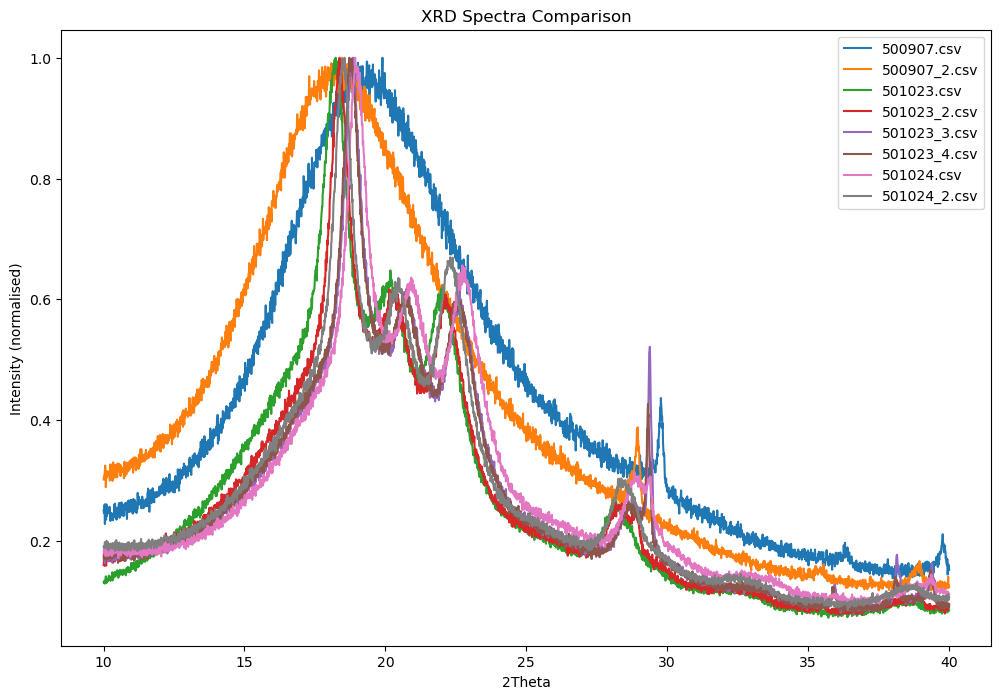

In [14]:
peek_files = [f for f in all_files if 'HDPE' not in f]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
for file in peek_files:
    ax.plot(df_dict[file]['2Theta'], df_dict[file]['Intensity_norm'], label=file)
ax.set_xlabel('2Theta')
ax.set_ylabel('Intensity (normalised)')
ax.set_title('XRD Spectra Comparison')
ax.legend()

## Hyperparameters

In [38]:
ref_peak_dict = {
    'PEEK': [18.7, 20.6, 22.7, 28.7],   # (110), (111), (200), (211)
    'HDPE': [21.5, 23.9, 30.0, 36.2]    # (110), (200), (210), (020)
}

# Provide specific crystalline peaks for each sample based on reference
sample_crys_peaks_dict = {
    '500907.csv': [i+1 for i in ref_peak_dict['PEEK']],    
    '500907_2.csv': ref_peak_dict['PEEK'],    
    '501023.csv': [i-0.5 for i in ref_peak_dict['PEEK']],
    '501023_2.csv': ref_peak_dict['PEEK'],
    '501023_3.csv': [i for i in ref_peak_dict['PEEK']],
    '501023_4.csv': ref_peak_dict['PEEK'],
    '501024.csv': ref_peak_dict['PEEK'],
    '501024_2.csv': ref_peak_dict['PEEK'],
    'HDPE.csv': ref_peak_dict['HDPE'],
    'HDPE_2.csv': ref_peak_dict['HDPE'],
    'HDPE_3.csv': ref_peak_dict['HDPE'],
    'HDPE_4.csv': ref_peak_dict['HDPE'],
}

known_amorp_peaks_dict = {
    'PEEK': [9, 19, 22, 29, 37],
    'HDPE': [14, 17, 20, 24, 30]
}

height_width_threshold_dict = {
    'PEEK': 0.05,  # tuned
    'HDPE': 0.008,  # tuned
}

min_prominence_dict = {
    'PEEK': 0.008,  # tuned
    'HDPE': 0.001,  # tuned
}

## Detailed algorithm

In [ ]:
# # Fit individual XRD spectrum
# ref_peak_dict = {
#     'PEEK': [18.7, 20.6, 22.7, 28.7],   # (110), (111), (200), (211)
#     'HDPE': [21.5, 23.9, 30.0, 36.2]    # (110), (200), (210), (020)
# }

# # Provide specific crystalline peaks for each sample based on reference
# sample_crys_peaks_dict = {
#     '500907.csv': [i+1 for i in ref_peak_dict['PEEK']],    # tuned
#     '500907_2.csv': ref_peak_dict['PEEK'],      #tuned
#     '501023.csv': [18.7-0.2, 20.6, 22.7, 28.7], # tuned
#     '501023_2.csv': ref_peak_dict['PEEK'],  # tuned
#     '501024.csv': ref_peak_dict['PEEK'],    # tuned
#     '501024_2.csv': ref_peak_dict['PEEK'],  # tuned
#     'HDPE.csv': ref_peak_dict['HDPE'],
#     'HDPE_2.csv': ref_peak_dict['HDPE'],
#     'HDPE_3.csv': ref_peak_dict['HDPE'],
#     'HDPE_4.csv': ref_peak_dict['HDPE'],
# }

# known_amorp_peaks_dict = {
#     'PEEK': [9, 19, 22, 29, 37],
#     'HDPE': [14, 17, 20, 24, 30]
# }

Processing file: 501023.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9253

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.2°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 20.18° as crystalline: height/width=1.05, width=0.57° (known position)
Classifying peak at 22.04° as crystalline: height/width=0.78, width=0.75° (known position)
  Peak at 18.2°: DETECTED but low quality score: -1.909
    - SNR: 3.02, Correlation: 0.292, RMSE improvement: -0.30792
  Testing peak at 20.1°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 20.10° as crystalline: height/width=1.05, width=0.57° (known position)
Classifyi

C:\Users\sieun\AppData\Local\Temp\ipykernel_6560\1661693583.py:234: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity,


Success with unbounded fit
Classifying peak at 18.22° as crystalline: height/width=1.18, width=0.32° (known position)
Classifying peak at 22.11° as crystalline: height/width=0.50, width=0.51° (known position)
Classifying peak at 28.27° as crystalline: height/width=0.19, width=0.51° (known position)
Classifying peak at 20.22° as crystalline: height/width=0.38, width=0.42° (known position)
  Progress: 10/11 combinations tested
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 20.10° as crystalline: height/width=1.05, width=0.57° (known position)
Classifying peak at 22.20° as crystalline: height/width=0.78, width=0.75° (known position)
  Progress: 11/11 combinations tested
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 

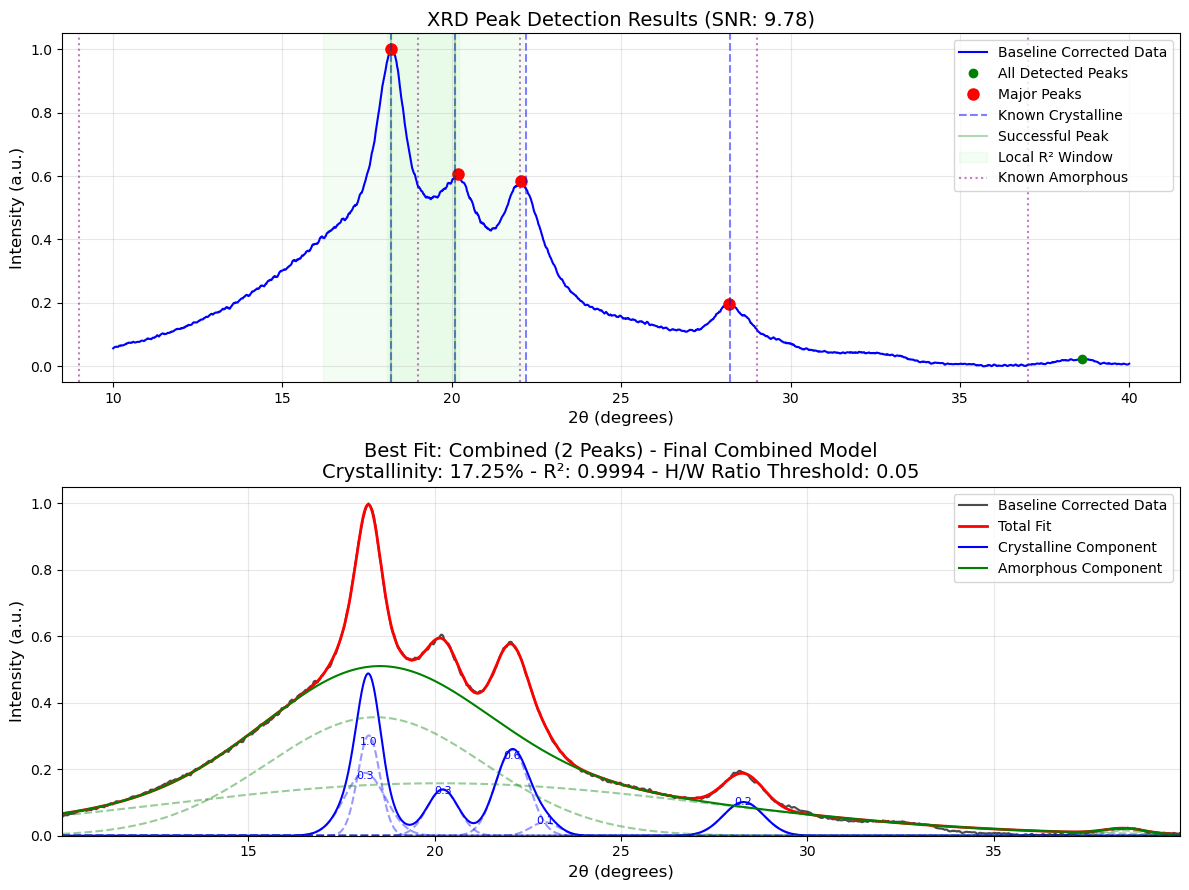

In [ ]:
# Dictionaries to store results
results_dict = {}
cryst_dict = {}  
 
# Fit individual file
for file in ['501023.csv']:
    print(f"Processing file: {file}")
    if 'HDPE' in file:
        polymer = 'HDPE'
    else:
        polymer = 'PEEK'
    data = df_dict[file]
    intensity = data['Intensity_norm'].values
    two_theta = data['2Theta'].values
    
    results = fit_xrd_spectrum_detailed(two_theta, intensity, 
                               known_crys_peaks=sample_crys_peaks_dict.get(file, None),
                            #    known_crys_peaks=[18.7-0.1, 20.6, 22.7, 28.7],
                            #    known_crys_peaks=[18.7-0.2, 20.6, 22.7, 28.7],
                               known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
                               height_width_threshold=height_width_threshold_dict[polymer], 
                               min_r_squared=0.95, amorphous_r_squared=0.90,
                               visualise=True)
    
    results_dict[file] = results
    cryst_dict[file] = results['crystallinity']

In [20]:
# # Fit all files
# cryst_dict = {}
# results_dict = {}
# for file in all_files:
#     print(f"Processing file: {file}")
#     if 'HDPE' in file:
#         polymer = 'HDPE'
#     else:
#         polymer = 'PEEK'
#     data = df_dict[file]
#     intensity = data['Intensity_norm'].values
#     two_theta = data['2Theta'].values
    
#     results = fit_xrd_spectrum(two_theta, intensity, 
#                                known_crys_peaks=sample_crys_peaks_dict.get(file, None),
#                                known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
#                                height_width_threshold=0.05, min_r_squared=0.999, amorphous_r_squared=0.90,
#                                visualise=True)
    
#     cryst_dict[file] = results['crystallinity']
#     results_dict[file] = results

Plot comparison.

In [43]:
# # Plot comparison plot
# from matplotlib.patches import Patch

# # Create bar chart for crystallinity results
# plt.figure(figsize=(12, 6))
# files = list(cryst_dict.keys())
# crystallinity_values = list(cryst_dict.values())

# # Create color mapping for different polymers
# colors = ['blue' if 'HDPE' in file else 'orange' for file in files]

# bars = plt.bar(files, crystallinity_values, color=colors, alpha=0.7)

# # Add value labels on top of bars
# for bar, value in zip(bars, crystallinity_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
#              f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# plt.xlabel('Sample Files', fontsize=12)
# plt.ylabel('Crystallinity (%)', fontsize=12)
# plt.title('XRD Crystallinity Analysis Results', fontsize=14)
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', alpha=0.3)

# # Add legend
# legend_elements = [Patch(facecolor='blue', alpha=0.7, label='HDPE'),
#                    Patch(facecolor='orange', alpha=0.7, label='PEEK')]
# plt.legend(handles=legend_elements, loc='upper left')

# plt.tight_layout()
# plt.show()

## Export and plot

In [44]:
import pandas as pd
import os

"""
Export all XRD fitting results to a single Excel file with multiple tabs
"""
# Create results directory if it doesn't exist
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

# Create Excel file path with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = os.path.join(results_dir, f"XRD_results.xlsx")

# Create Excel writer object
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    
    # Lists to store overview data
    overview_data = []
    
    print("\nProcessing files for Excel export...")
    
    # Process each file
    for file in all_files:
        print(f"Processing {file}...")
        
        # Determine polymer type
        if 'HDPE' in file:
            polymer = 'HDPE'
        else:
            polymer = 'PEEK'
        
        # Get data
        data = df_dict[file]
        intensity = data['Intensity_norm'].values
        two_theta = data['2Theta'].values
        
        # Get XRD fitting
        results = results_dict[file]
        
        # Create tab name (remove file extension and sanitize for Excel)
        tab_name = os.path.splitext(file)[0]
        # Excel tab names have a 31 character limit and can't contain certain characters
        tab_name = tab_name.replace('[', '').replace(']', '').replace('*', '').replace('?', '').replace('/', '').replace('\\', '')
        if len(tab_name) > 31:
            tab_name = tab_name[:31]
        
        # Create DataFrame for this spectrum
        spectrum_df = pd.DataFrame({
            '2Theta_deg': two_theta,
            'Original_Intensity_normalized': results.get('baseline_corrected_intensity', intensity),
            'Total_Fit': results['total_fit'],
            'Crystalline_Fit': results['crystalline_fit'],
            'Amorphous_Fit': results['amorphous_fit'],
            'Residuals': results['residuals']
        })
        
        # Add spectrum to Excel file
        spectrum_df.to_excel(writer, sheet_name=tab_name, index=False)
        
        # Collect overview data
        overview_row = {
            'Filename': file,
            'Polymer_Type': polymer,
            'Crystallinity_percent': round(results['crystallinity'], 2),
            'R_squared': round(results['r_squared'], 4),
            'RMSE': round(results['rmse'], 6),
        }
        
        overview_data.append(overview_row)
    
    # Create overview DataFrame
    overview_df = pd.DataFrame(overview_data)
    
    # Add overview tab at the beginning
    overview_df.to_excel(writer, sheet_name='Overview', index=False)
    
    print(f"\nExcel file saved: {excel_filename}")   


Processing files for Excel export...
Processing 500907.csv...
Processing 500907_2.csv...
Processing 501023.csv...
Processing 501023_2.csv...
Processing 501023_3.csv...
Processing 501023_4.csv...
Processing 501024.csv...
Processing 501024_2.csv...
Processing HDPE.csv...
Processing HDPE_2.csv...
Processing HDPE_3.csv...
Processing HDPE_4.csv...

Excel file saved: ../results\XRD_results.xlsx


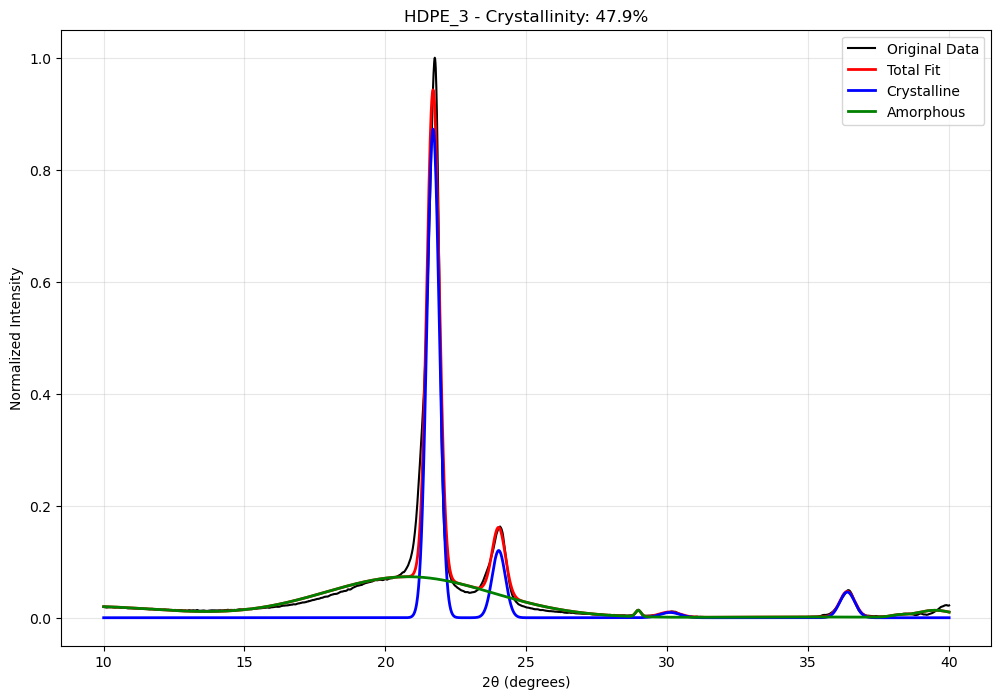

In [47]:
def plot_xrd_from_excel(excel_file_path, sample_name):
    """
    Read Excel file and plot XRD analysis results for a specific sample.
    
    Parameters:
    -----------
    excel_file_path : str
        Path to the Excel file
    sample_name : str
        Sample name (e.g., '501023_1')
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    # Load overview to find sample info
    overview_df = pd.read_excel(excel_file_path, sheet_name='Overview')
    sample_row = overview_df[overview_df['Filename'].str.contains(sample_name, case=False, na=False)]
    
    if sample_row.empty:
        print(f"Sample '{sample_name}' not found")
        return
    
    sample_info = sample_row.iloc[0]
    
    # Create tab name
    tab_name = os.path.splitext(sample_info['Filename'])[0]
    if len(tab_name) > 31:
        tab_name = tab_name[:31]
    
    # Load spectrum data
    spectrum_df = pd.read_excel(excel_file_path, sheet_name=tab_name)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    plt.plot(spectrum_df['2Theta_deg'], spectrum_df['Original_Intensity_normalized'], 
             'k-', linewidth=1.5, label='Original Data')
    plt.plot(spectrum_df['2Theta_deg'], spectrum_df['Total_Fit'], 
             'r-', linewidth=2, label='Total Fit')
    plt.plot(spectrum_df['2Theta_deg'], spectrum_df['Crystalline_Fit'], 
             'b-', linewidth=2, label='Crystalline')
    plt.plot(spectrum_df['2Theta_deg'], spectrum_df['Amorphous_Fit'], 
             'g-', linewidth=2, label='Amorphous')
    
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Normalized Intensity')
    plt.title(f"{sample_name} - Crystallinity: {sample_info['Crystallinity_percent']:.1f}%")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Usage
plot_xrd_from_excel('../results/XRD_results.xlsx', 'HDPE_3')

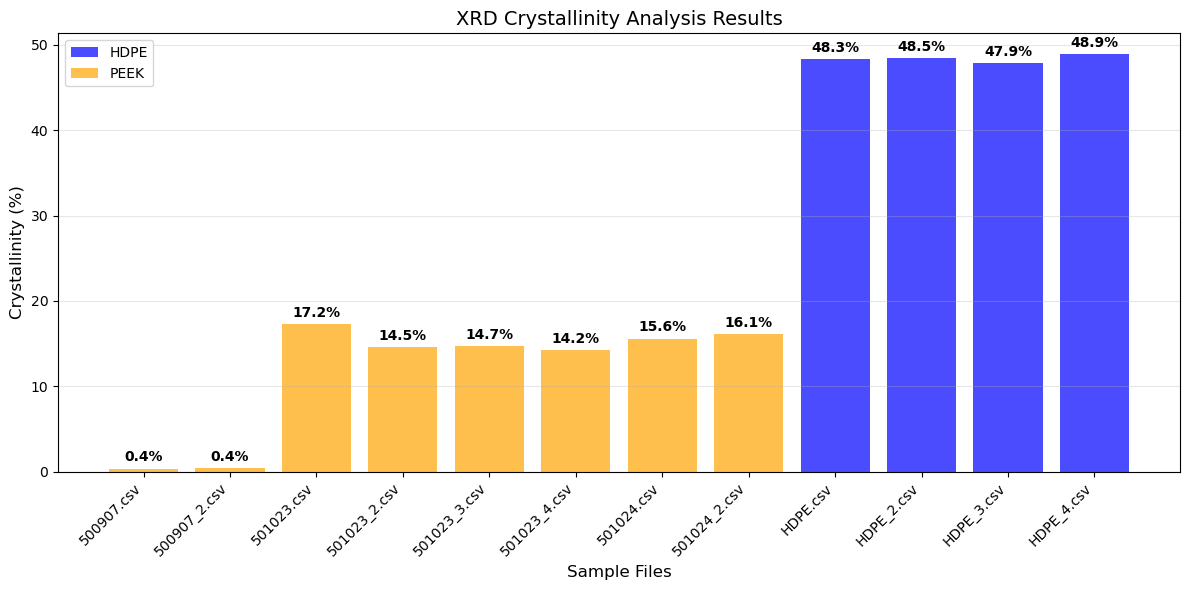

In [46]:
def plot_crystallinity_from_excel(excel_file_path):
    # Plot comparison plot
    from matplotlib.patches import Patch
    
    # Store results
    overview_df = pd.read_excel(excel_file_path, sheet_name='Overview')
    cryst_dict = dict(zip(overview_df['Filename'], overview_df['Crystallinity_percent']))    
    files = list(cryst_dict.keys())
    crystallinity_values = list(cryst_dict.values())

    # Create color mapping for different polymers
    colors = ['blue' if 'HDPE' in file else 'orange' for file in files]

    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(files, crystallinity_values, color=colors, alpha=0.7)

    # Add value labels on top of bars
    for bar, value in zip(bars, crystallinity_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Sample Files', fontsize=12)
    plt.ylabel('Crystallinity (%)', fontsize=12)
    plt.title('XRD Crystallinity Analysis Results', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add legend
    legend_elements = [Patch(facecolor='blue', alpha=0.7, label='HDPE'),
                    Patch(facecolor='orange', alpha=0.7, label='PEEK')]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()
    plt.show()

# Usage
plot_crystallinity_from_excel('../results/XRD_results.xlsx')